# CNN CIFAR-10

## Imports

In [1]:
import os

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import wandb

In [29]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

print(mps_device)

mps


## Load Dataset

In [35]:
transform = transforms.Compose([
    # transform to pytorch Tensor, which also scales the values to [0, 1]
    transforms.ToTensor(), 
    # normalize the tensor with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5) for each of the three color channels (RGB) of the image
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

batch_size = 16

trainset_notransform = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## EDA and Preprocessing

### Looking at some images

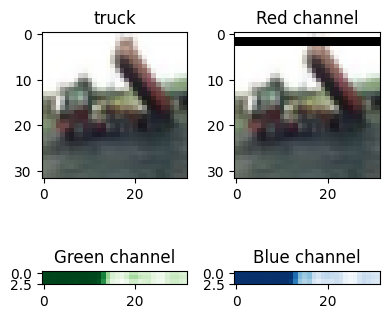

In [44]:
# plot an image from the dataset
def plot_image(id, dataset):
    img = dataset.data[id]

    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()

    axs[0].imshow(img)
    axs[0].set_title(dataset.classes[dataset.targets[id]])

    # img to torch tensor
    img = torch.from_numpy(img).permute(2, 0, 1).float() / 255

    axs[1].imshow(img[:,:,0], cmap='Reds')
    axs[1].set_title('Red channel')

    axs[2].imshow(img[:,:,1], cmap='Greens')
    axs[2].set_title('Green channel')

    axs[3].imshow(img[:,:,2], cmap='Blues')
    axs[3].set_title('Blue channel')

    plt.tight_layout()
    plt.show()

plot_image(2, trainset)

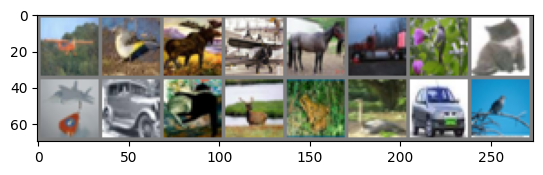

plane    bird     deer     plane    horse    truck    bird     cat      plane    car      cat      deer     frog     bird     car      bird    


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:8s}' for j in range(batch_size)))

### Class Distribution

As expected based on the dataset's description, the CIFAR10 dataset includes 50'000 images for each class in the training dataset and is therefore balanced.

{6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}


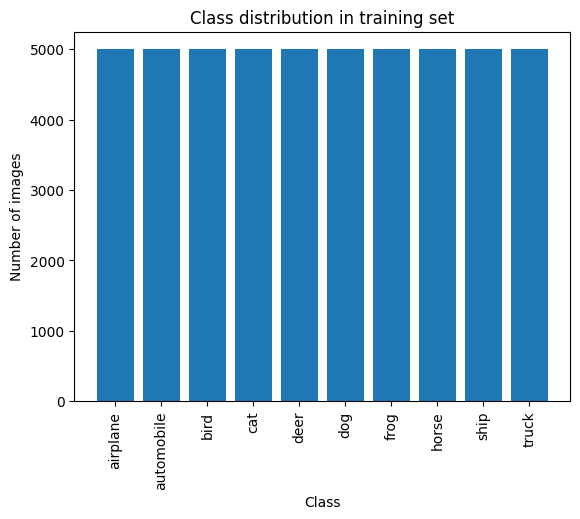

In [18]:
# Check the distribution of the classes in the training set
def show_class_distribution(dataset):
    class_count_dict = {}
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in class_count_dict:
            class_count_dict[dataset.targets[i]] += 1
        else:
            class_count_dict[dataset.targets[i]] = 1
    for i in range(10):
        if i not in class_count_dict:
            class_count_dict[i] = 0

    print(class_count_dict)

    # plot bar plot with target labels
    plt.bar(range(len(class_count_dict)), list(class_count_dict.values()), align='center')
    plt.xticks(range(len(class_count_dict)), dataset.classes, rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution in training set')

    plt.show()

show_class_distribution(trainset)

## CNN Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(mps_device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
x = torch.zeros(1, 3)
x.device

device(type='cpu')

### Loss Function and Optimizer

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Metrics

In [20]:
def calculate_accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            # move batch to GPU
            images = images.to(mps_device)
            labels = labels.to(mps_device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

### Training the Model

In [21]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'mini-challenge-1.ipynb'

# Setup Weight & Biases
wandb.init(
    # set the wandb project where this run will be logged
    entity='yvokeller',
    project='deep-learning',
    # track hyperparameters and run metadata
    config={
        'learning_rate': 0.02,
        'architecture': 'CNN',
        'dataset': 'CIFAR-10',
        'epochs': 2,
    }
)

In [22]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move batch to GPU
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

            train_accuracy = calculate_accuracy(net, trainloader)
            test_accuracy = calculate_accuracy(net, testloader)
            print(f'Train accuracy: {train_accuracy:.2f}%')
            print(f'Val accuracy: {test_accuracy:.2f}%')

            wandb.log({'loss': loss, 'train_acc': train_accuracy, 'test_acc': test_accuracy})

wandb.finish()
print('Finished Training')

[1,  2000] loss: 2.166
Train accuracy: 31.01%
Val accuracy: 31.42%
[2,  2000] loss: 1.590
Train accuracy: 45.13%
Val accuracy: 45.42%


loss,█▁
test_acc,▁█
train_acc,▁█
loss,1.12828
test_acc,45.42
train_acc,45.132


Finished Training


In [23]:
MODEL_PATH = './cifar_net.pth'
torch.save(net.state_dict(), MODEL_PATH)

### Testing the Model

#### Ground Truth

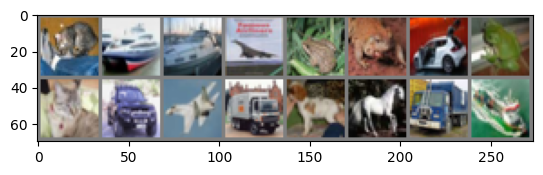

GroundTruth:  cat   ship  ship  plane


In [24]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#### Model Prediction

In [25]:
net = Net()
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [26]:
# Predict
outputs = net(images)
outputs

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   ship  ship 
